## **Problem Statement**
**Context**: Online food and grocery stores (e.g. Big Basket, Dmart) lists different packaged food with ingredients and Nutitional details of food . It must be challenging for such organization to categorize food items listing . Sometimes categorising for consumers based on content that food item has .

Following problems we can solve based on Ingredients and Nutrition images :
 - If food contains any harmful contents - may be for child
 - If has specific high content of sugar , which may not be good for specific consumer such diabitic patient
 - More presevative content
 - Find best alternatives of such food products

**Objective**: Need to be able to identify the various such named entities.

## 1. Import Libraries

In [14]:
import requests
import json
import urllib.request
import os
import time
from pathlib import Path
import time
import re
import random
import string      # for string operations

# For web scapping
from bs4 import BeautifulSoup as soup

# Tracking progress
from tqdm.notebook import tqdm
# Reading and processing image
from PIL import Image

import warnings
# Settings the warnings to be ignored
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from wordcloud import WordCloud

import seaborn as sns

# Import label encoder
from sklearn import preprocessing
# Bag of words
from sklearn.feature_extraction.text import CountVectorizer
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# For dimentionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Normalise data
from sklearn.preprocessing import StandardScaler
# Clustering
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

### 1.1 Install Pre-requisites

In [15]:
!pip install pytesseract

In [16]:
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 15 not upgraded.
Need to get 4,850 kB of archives.
After this operation, 16.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1 [1,598 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr amd64 4.1.1-2build2 [262 kB]
Fetched 4,850 kB in 0s (17.4 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/Fron

In [17]:
!pip install opencv-python

In [18]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 12.1 MB/s eta 0:00:00


In [19]:
!pip install keras-preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.6 MB/s eta 0:00:00


In [20]:
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 9.8 MB/s eta 0:00:00


In [21]:
import cv2
import pytesseract as pt

import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from gensim.models import Word2Vec
from keras.models import Model
from keras.layers import Embedding, LSTM, Dense, TimeDistributed, Dropout, Bidirectional, Input
from tensorflow_addons.utils.types import FloatTensorLike, TensorLike

# LSTM components
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

# CRF layer
from tensorflow_addons.layers import CRF

# Sigmoid focal cross entropy loss. works well with highly unbalanced input data
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from tensorflow_addons.optimizers import AdamW
from tensorflow.keras.optimizers import Adam

from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Plots
import matplotlib.pyplot as plt

# Spacy specific libraries
import spacy
import contractions

## 2. Set Configurations

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
# Set Big Basket API Base URL
API_BASE_URL = 'https://www.bigbasket.com/custompage/sysgenpd/?type={}&slug={}'

# Set Big Basket Image Base URL
SOURCE_PRODUCT_IMAGE_DOWNLOAD_BASE_URL = "https://www.bigbasket.com/media/uploads/p/s/"
SOURCE_PRODUCT_PROP_IMAGE_DOWNLOAD_BASE_URL = "https://www.bigbasket.com/media/uploads/p/xxl/"

# Set Image download path
INGR_IMAGE_DOWNLOAD_PATH = "BB_IMAGE_DOWNLOAD_PATH/Ingredients"
NUTRITION_IMAGE_DOWNLOAD_PATH = "BB_IMAGE_DOWNLOAD_PATH/Nutrition"
PRODUCT_IMAGE_DOWNLOAD_PATH = "BB_IMAGE_DOWNLOAD_PATH/Product"
PRODUCT_TYPE_SLUG_DETAILS_CSV_PATH = "BB_DATA_PATH/CSV"

# Set Sample image path for Image to text convertion
HQ_IMAGE_SOURCE="/content/sample_data/"
DRIVE_INGRDNT_IMAGE_SRC="/content/drive/MyDrive/PP-IMAGE-DIR/INGRIDIENTS"
DRIVE_NUTRITION_IMAGE_SRC="/content/drive/MyDrive/PP-IMAGE-DIR/NUTRITION"
DRIVE_CSV_LOC = "/content/drive/MyDrive/PP-IMAGE-DIR/CSV"

# Custom config for OCR convertion
#OCR_CUSTOM_CONFIG = r'--oem 3 --psm 6'
OCR_CUSTOM_CONFIG = ('-l eng --oem 1 --psm 3')

tqdm.pandas()
# GLOVE CONFIGURATION FILE
# Download GloVe pre-trained word vectors
"""
STEP 1 : Visit the GloVe project website at https://nlp.stanford.edu/projects/glove/.
STEP 2: Scroll down to the "Download pre-trained word vectors" section.
STEP 3: There are various pre-trained GloVe vector files available with different dimensions and corpus sizes. Choose the one that suits your requirements. For example, you can
STEP 4: Once the ZIP file is downloaded, extract its contents to obtain the GloVe vectors file.

"""
GLOVE_FILENAME='glove.6B.300d.txt'
GLOVE_CONFIG_DIR ="/content/drive/MyDrive/PP-IMAGE-DIR/GLOVE"

### 2.1 Create Download directories

In [24]:
Path(INGR_IMAGE_DOWNLOAD_PATH).mkdir(parents=True, exist_ok=True)
Path(NUTRITION_IMAGE_DOWNLOAD_PATH).mkdir(parents=True, exist_ok=True)
Path(PRODUCT_IMAGE_DOWNLOAD_PATH).mkdir(parents=True, exist_ok=True)
Path(PRODUCT_TYPE_SLUG_DETAILS_CSV_PATH).mkdir(parents=True, exist_ok=True)

## 3. Data Extraction

### 3.1 Scrape Data

In [25]:
def get_product_image_name(text):
    matched = re.search('(\d+)_(\d+)-(.*)', text)
    if matched:
        return matched.group(3)
    else:
        return ""

In [26]:
def scrape_bigbasket_data(product_type,slug):
    # Set url based on product type and slug
    url = API_BASE_URL.format(product_type,slug)

    # Set user agent header to avoid blocking
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.61 Safari/537.36'}

    # Send a GET request to the provided URL
    response = requests.get(url, headers=headers)

    # Create BeautifulSoup object
    bsobj = soup(response.content)

    # Parse the JSON data from the response
    comp = json.loads(response.text)['tab_info']

    # Extract product information
    product_ids = []
    product_names = []
    mrps = []
    special_prices = []
    product_image_urls = []
    ingrdnt_image_urls = []
    nutrition_image_urls = []

    for product in comp[0]['product_info']['products']:
        product_ids.append(product['sku'])
        product_names.append(product['p_desc'])
        mrps.append(product['mrp'])
        special_prices.append(product['sp'])

        # Extract the download URLs for product images
        product_image_path_vals = product['p_img_url'].split("/")
        product_image_download_url = SOURCE_PRODUCT_IMAGE_DOWNLOAD_BASE_URL + product_image_path_vals[-1]
        product_image_urls.append(product_image_download_url)

        # Extract the download URLs for ingredient images and nutrition images
        #tmp_image_name = product_image_path_vals[-1].split("_")
        processed_image_name = get_product_image_name(product_image_path_vals[-1])
        #ingrdnt_image_download_url = SOURCE_PRODUCT_PROP_IMAGE_DOWNLOAD_BASE_URL + str(product['sku']) + "-3_" + tmp_image_name[-1]
        ingrdnt_image_download_url = SOURCE_PRODUCT_PROP_IMAGE_DOWNLOAD_BASE_URL + str(product['sku']) + "-3_1-" + processed_image_name

        #nutrition_image_download_url = SOURCE_PRODUCT_PROP_IMAGE_DOWNLOAD_BASE_URL + str(product['sku']) + "-4_" + tmp_image_name[-1]
        nutrition_image_download_url = SOURCE_PRODUCT_PROP_IMAGE_DOWNLOAD_BASE_URL + str(product['sku']) + "-4_1-" + processed_image_name

        ingrdnt_image_urls.append(ingrdnt_image_download_url)
        nutrition_image_urls.append(nutrition_image_download_url)

    # Create a DataFrame from the extracted data
    bigb = {
        'Product_Id': product_ids,
        'Product_name': product_names,
        'Product_image_url': product_image_urls,
        'Ingrident_image_url': ingrdnt_image_urls,
        'Nutrition_image_url': nutrition_image_urls,
        'MRP': mrps,
        'Special_price': special_prices
    }

    df = pd.DataFrame.from_dict(bigb)

    # Save processsed data for future reference
    timestr = time.strftime("%Y%m%d-%H%M%S")
    PRODUCT_TYPE_SLUG_CSV_FILENAME = PRODUCT_TYPE_SLUG_DETAILS_CSV_PATH +"/"+product_type+"-"+slug+"-"+timestr+".csv"

    df.to_csv(PRODUCT_TYPE_SLUG_CSV_FILENAME)

    return df

### 3.2 Download Image Data

In [27]:
# Function to download an image
def download_image(url, folder_path):
    try:
        filename = os.path.basename(url)
        file_path = os.path.join(folder_path, filename)
        urllib.request.urlretrieve(url, file_path)
        print(f"Downloaded: {url}")
    except Exception as e:
        print(f"Error occurred while downloading: {url}")
        print(str(e))

In [28]:
def download_image_by_product_type_n_slug(product_type,slug):
    # Scrape by product_type,slug
    df = scrape_bigbasket_data(product_type,slug)

    # Download all ingredient images by product type and slug
    for ingredient_image_url in df["Ingrident_image_url"].to_list():
      download_image(ingredient_image_url, INGR_IMAGE_DOWNLOAD_PATH)

    # Download all Nutrition images by product type and slug
    for nutrition_image_url in df["Nutrition_image_url"].to_list():
      download_image(nutrition_image_url, NUTRITION_IMAGE_DOWNLOAD_PATH)

    # Download all product images by product type and slug
    for product_image_url in df["Product_image_url"].to_list():
      download_image(product_image_url, PRODUCT_IMAGE_DOWNLOAD_PATH)

### 3.2.1 Initialize product and food brands

In [ ]:
# Top 20 brands
#product_brand_names = ["haldirams","saffola","kissan","nestle","parle","britannia","mtr","cadbury","amul","McCain","godrej","kwality","Pepsi","Patanjali","Hatsun","Sunfeast","protinex","nutella","auric","sundrop","tang","knorr"]
# All brands in Big basket
product_brand_names=["24-Mantra","24-Mantra-Organic","Aachi","Aashirvaad","Aashirvaad-Svasti","ALLEGRO","Amul","Annapoorna","Anveshan","Arya-Organic","Barosi","BB-Popular","BB-Royal","BB-Royal-Organic","BB-Super-Saver","Bb-Super-Saver-Premium","Beantree","Bertolli","Bobs-Red-Mill","BORGES","By-Nature","Catch","Ceres-Foods","Chandan","Chekko","Chukde","Coco-Soul","Colavita","Cornitos","Daawat","Dabur","Deccan-mudra","Dehaat-Honest-Farms","Del-Monte","Delicious","Delight-Foods","Delight-Nuts","Dhampur-Green","Dhara","Dhatu-Organics-&-Naturals","Disano","Dnv","Double-Horse","Earthon","Eastern","Elite","Emami","Emami-Healthy-&-Tasty","Equal","Everest","Everyday-Four","Fabbox","Falcon","Farmley","Figaro","Flavour-Drum","Forgreen","Fortune","Freedom","Freshmill-Oils","Fresho","Fresho-Organic","Fresho-Signature","Gaia","GEETARTH","Gemini","Geo-Fresh","GoodDiet","Gowardhan","Gramas-Spices","Grami-Superfood","Graminway","GRB","Green-valley","Greenz-In","Grocery-Farm","Gudmom","Hakim","Happilo","HappyChef","Harin","Harveys","Health-1st","Healthy-Fibres","Herbs-Hi","Heritage","Himalayan-Natives","Homefills","India-Gate","Isvaari","Jawai","Jivo","Jiwa","JK","JK-MASALE","JOMARA","Kapiva","Keya","Klf","Kohinoor","Kpl-Shudhi","Kwality","La-Espanola","Licious","Lion","LO!-Foods","Madhur","Madilu","Manna","Mdh","Merkera","MOMZIE","MTR","NAGA","Nature-Way","Natureland-Organics","Naturesmith","Nourish-you","NUTRAJ-BACTOPURE","Nutrashil","Nutrela","Nutriorg","Nutriwish","Nutty-Gritties","Nutty-Yogi","Oleev","On1y","Organic-India","Organic-Nation","ORGANIC-ORIGINS","Organic-Tattva","Orika","Pantai","Patanjali","Phalada-Pure-&-Sure","Pillsbury","Porna","Praakritik","PRISTINE","Priya","Pro-Nature","ProV","Rafael-Salgado","Rampura","RAS-CHEKKU-OIL","REAL-THAI","REGENCY","RISI-SPICES","Rooted-Peepul","Rostaa","Safe-Harvest","Saffola","Sahasthra","Sakthi","Salz-&-Aroma","Samvruddhi","Slurrp-Farm","Smith-&-Jones","SNAPIN","SNN","Sparsh","Sprig","Sri-Sri-Tattva","Stories","Sugar-free","Sunpure","Super-Saver","Swarnanjali","Tablespoon","Tasties","Tasty-Nibbles","Tata-Salt","Tata-Sampann","Teju","Terra-Greens","The-Better-Flour","Tilda","Tong-Garden","True-Elements","Truefarm","Tt","Tummy-Pops","Turn-Organic","Udupi-Ruchi","Valley-Spice","Vijay","VOILA","Wild-Ideas","Yours","Zoff","AKSHAYAKALPA","Alt-Co","Amulya","ARLA","Auric","AWSUM","Bagrrys","Baskin-Robbins","Bauli","BB-Monsoon-Combo","Bhikhaaram-Chandmal","Blue-Bird","Bon-&-Bread","Bonn","Britannia","Britannia-Treat","BRIYAS","Brownies-Basket","Cadbury-Chocobakes","Cavins","Christopher-Cocoa","CookieMan","Cothas","Cream-Bell","Dairy-Craft","Dairy-day","DaVinci-Gourmet","Delishh","Dibha","Dodoni","Dream-Bake","e-millet","English-Oven","Epigamia","Epigamia-Origins","Farm-Connect","FLISTAA","Foodstrong-Juniors","Go","Godrej-Jersey","Grabenord","Hangyo","Havmor","Health-on-Plants","Hello-Tempayy","Hersheys","Hyperscoop","iD","iD-Fresho","Jersey","Jus-Amazin","Just-Plants","Kara","Katharos","Kodai-Cheese","Kraft","kwality-walls","La-Cremella","La-Tranche","Lal","Lavian-Exotique","Lindberg","London-Dairy","Malkist","Mamie-Yova","Milk-Ma","Milky-Mist","Millet-Cookies","MODERN","MOOZ","Mother-Dairy","Nandini","Nandini-GoodLife","Nescafe","Nestle","Nestle-A+","NIC","NOTO","Nourish-Organics","NUTORAS","Nutralite","Nutribee","One-Good","Only-Earth","Open-Secret","Orion","PAPACREAM","Paper-Boat","Parle","Plantaway","Praana","PRESIDENT","Pure-Diet","QUILLA","R-K-Soya","Rage-Coffee","Raw-Pressery","Real","RRO-DAIRY","Shaka-Harry","SHREEMATHA","Sids-Farm","Skippi-Icepops","Sleepy-Owl","Smoodh","So-Good","Sofit","Soyfit","Sprinng","Storia","Sunfeast","Supreem-Super-Foods","THE-BROOKLYN-CREAMERY","The-Health-Factory","The-Laughing-Cow","Ultx","UNROLL","Urban-Platter","White-Cub","Wingreens-Farms","Winkies","Yakult","Yes-You-Can","Yoga-Bar","Yoghino","3-Roses","7-Up","Alkalen","Alo-Frut","ALPHA-8","Appy","Appy-Fizz","Aquafina","Arka","B-Natural","Baidyanath","Barbican","Bayars","Bean-Good","Beyondarie","Bindu","Bisleri","Blue-Tokai","Bombay-99","Bombucha","Boost","Borecha","BORN-HILL","BRU","Cadbury","Cadbury-Bournvita","Cambridge-Tea-Party","Carl-Jung","Chaika","Coca-Cola","Cocojal","Cocomama","Coffeeza","Colombian-Brew-Coffee","Complan","Continental","Continental-Coffee","Continental-Malgudi","Coolberg","Cothas-Coffee","Country-Bean","Dash-of-RCB","Davidoff","Desi-Utthana","Diabetics-Dezire","Dorje","EARTHMADE-ORGANIX","Eco-Valley","Emoticup","Emperia","Enchanteas","Ensure","ENSURE-DIABETES-CARE","Esah-Tea","Fanta","Frooti","FRUSSH","Gatorade","Girnar","Glucon-D","Golden-Tips","Groviva","Gulabs","Hamdard","Himalayan","Horlicks","IncredaBrew","IndiSecrets","Kangra-Tea-House","Karma-Kettle","Kinley","Leo","LEVISTA","Lipton","Local-Ferment-Co","Maaza","MAGICSIP-COFFEE","Malas","Mapro","Marvel","Marvel-Tea","Mirinda","Mlesna","Mojoco","Monin","Monster","Mountain-Dew","Narasus","Natures","Nescafe-Classic","Nescafe-Gold","Olinda","Organica","Paperboat-Swing","Pediasure","Pepsi","Perfetto","Protinex","Qualinut-Gourmet","Rasna","Real-Activ","RED-BULL","Red-Label","Riseup","Roshi","Saburi","Saffola-FITTIFY-Gourmet","Sante","Satheesh-Kaapi","Schweppes","Sericha","Sippin","Slice","Smoodies","Sprig-Tea","Sprite","Sting","Sunbean","Swa-Artisanal-Syrups","T-GO","Taj-Mahal","Tang","Tata-Coffee","Tata-Coffee-Grand","Tata-Soulfull","Tata-Tea","Tata-Tea-Agni","Tata-Tea-Chakra","Tata-Tea-Chakra-Gold","Tata-Tea-Gemini","Tata-Tea-Gold","Tata-Tea-Kanan-Devan","Tata-Tea-Premium","Tea-Bro","Teabox","TEAFIT","Teamonk","TEAS-FROM-INDIA","Tetley","Thums-Up","Timios","Tropicana","TummyFriendly-Foods","Twinings","Typhoo","umami-brew","Vahdam","Vidya-Ground","Wagh-Bakri","WaghBakri","Weikfield","Wow!-Coco-Charge","Zenzi","A-1-Chips","Abbies","ACT-II","ADF-Soul","ALPENLIEBE","Alpino","American-Garden","Ask-Foods","Atish","BAKERS","Balaji-foods","BALASA","Bambino","Barilla","Beanut","Beyond-Snack","BHUIRA","Bikaji","Bingo","Bisk-Farm","Blue-Flame","Bogutti","Britannia-NutriChoice","Buffet","Cadbury-Bournville","Cadbury-Dairy-Milk","Cadbury-Dairy-Milk-Silk","Cadbury-Oreo","Charlie","Chings","Cremica","Desi","Doritos","Dukes","Eagle","Fabelle","Farmveda","Fidra-Products","Future-Organics","Gits","Godrej-Yummiez","Golden-Prize","Gourmets-Delite","Grain-N-Grace","GRAMI-SUPERFOODS","Gujjubhai","GURUJEE-NAMKEEN","Habanero","Haldirams","Happy-Jars","Happy-Karma","Healthy-Dig","Heidi","Immunit","Inchi","ITC-Master-Chef","Iyers","JABSONS","Jacker","Karachi-Bakery","Kelloggs","Keventer","Kiara-Foods","Kissan","Knorr","Koka","Kurkure","La-Carne","La-Vieja-Fabrica","Lays","Lindt","Loacker","MAGGI","MasterChow","McCain","Meatzza","Mentos","MOI-SOI","Molo","Moments","Motherss-Recipe","NAAGIN","Neo","Nissin","Pintola","PLATTERED","Prasuma","Pringles","Puzzles","Quaker","Raju-Snacks","RiteBite-Max-Protein","Saffola-FITTIFY","Sanjay","Sanketi-Adukale","Sapphire","Sarati-Instant","SDA-PAPPADS","Snickers","Sugar-Watchers","Sugarless-Bliss","sumeru","Sundrop","Sunfeast-YiPPee!","Switz","TAALI","tagz","Tasties-Origins","Tasty-Fresh","Tata-Sampann-Yumside","Tex-Mex-Salsalito","The-Belgian","Tiffany","Too-Yumm!","Townbus","UNIBIC","VEEBA","Wai-Wai","WellBe","Wild-Date","Yu","Zerobeli","American-Delight","Americano","Anmara","Beanies","Bechef","BENGAMESE","Bloom","Blue-Dragon","Blue-Elephant","Bun-Maska","Burlyfield","Cafe-Junyali","Chokola","Cocoacraft","Cocosutra","Confect","Cravova","Cure-By-Design","Daarzel","Dana","Darkins","DiabeSmart","DON-MONTE","Flying-Goose","Fragata","FRUT","Galaxy","Gastone-Lago","GPC","Habit","HandS","Kettle-Studio","Leonz","Little-Italy","Long&Short","Lunn","Makino","Mantra","Marshmelts","Meishi","Monsoon-Harvest","MUSTIN","MYFITNESS","NAMASTE-CHAI","Natch","Naturally-Yours","Neuherbs","NONGSHIM","Noto-Ice-Cream","NutraHi","NUTTING-ELSE","Ocean-Secret","Ongs","OUI","Paldo","Paul-And-Mike","Puramate","Purix","Ragu","Riscossa","Ritter-Sport","Sakurafresh","Sancha","Serapheena","Skittles","So-Sweet","Tai-Hua","The-Gourmet-Jar","The-Whole-Truth","Under-The-Mango-Tree","Varahi","White-Castle","Wholesome-First"]

In [ ]:
#for product_brand in tqdm(product_brand_names):
#  print("Downloading image for brand name",product_brand)
#  download_image_by_product_type_n_slug("pb",product_brand)

## 4. Data Pre processing

### 4.1 Image pre-processing

In [ ]:
# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    # Apply various noise removal techniques to eliminate unwanted artifacts or distortions in the image.
    # Common approaches include blurring, median filtering, or morphological operations
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)  # Adjust the kernel size as needed
    cv2.imwrite('blurred_image.png', blurred_image)

    return cv2.medianBlur(image,5)

# thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

# dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)

# erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

# opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

# canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

# skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

# edge sharpen
def sharpen(image):
    # It's important to note that edge sharpening can sometimes amplify noise or artifacts in the image.
    # To mitigate this, it's recommended to apply appropriate image preprocessing techniques and
    # consider using additional filtering methods, such as Gaussian blurring, before applying edge sharpening.

    # In industry applications, the preferred method for edge sharpening in an image is often achieved using image
    # filtering techniques, specifically through the use of convolution kernels. One commonly used technique for edge
    # sharpening is the Laplacian filter.

    #kernel = np.array([[0, -1, 0],[-1, 5, -1],[0, -1, 0]])
    #sharpened = cv2.filter2D(image, -1, kernel)

    # Apply Laplacian filter for edge sharpening
    laplacian_kernel = np.array([[0, 1, 0],
                                [1, -4, 1],
                                [0, 1, 0]], dtype=np.float32)  # Laplacian kernel
    sharpened_image = cv2.filter2D(image, -1, laplacian_kernel)


    return sharpened_image

# increse contrast
def increase_contrast(image):
    # Increase contrast
    alpha = 1.5  # Adjust the contrast enhancement factor as needed
    enhanced_image = cv2.convertScaleAbs(image, alpha=alpha, beta=0)

    # Increase brightness
    #beta = 50  # Adjust the brightness enhancement factor as needed
    #enhanced_image = np.clip(enhanced_image + beta, 0, 255).astype(np.uint8)

    return enhanced_image

In [ ]:
# template matching
# Credit : https://nanonets.com/blog/ocr-with-tesseract/
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)

In [ ]:
def preprocess_image(image):

    image = get_grayscale(image)
    #image = remove_noise(image)
    #image = thresholding(image)
    #image = dilate(image)
    #image = erode(image)
    #image = opening(image)
    #image = canny(image)
    #image = deskew(image)

    #image = sharpen(image)
    #image = increase_contrast(image)

    return image

### 4.2 Image to Text

In [ ]:
def convert_image_to_text(image_dir,category="Ingredients"):
    # Extract product information
    product_names = []
    product_specs = []

    for filename in os.listdir(image_dir):
        #img = cv2.imread(os.path.join(image_dir,filename))
        img_file_path = os.path.join(image_dir,filename)
        # Open and convert the image to grayscale.
        img = Image.open(img_file_path).convert("L")
        if img is not None:
           # pre-process images
           #img_processed = preprocess_image(img)

           # Converting image to text
           img_arr = np.asarray(img)
           #text = pt.image_to_string(img_processed, config=OCR_CUSTOM_CONFIG)
           text = pt.image_to_string(img_arr)

           # Saving image context
           product_specs.append(text)
           product_file_name = os.path.splitext(filename)[0]
           product_names.append(product_file_name)

    # Create a DataFrame from the extracted data
    product_details = {
        'Product_name': product_names,
        category: product_specs
    }

    product_df = pd.DataFrame.from_dict(product_details)

    # Save processsed data for future reference
    timestr = time.strftime("%Y%m%d-%H%M%S")
    if category == "Ingredients":
      INGR_CSV_FILENAME = DRIVE_CSV_LOC +"/Ingridients-"+timestr+".csv"
    else:
      INGR_CSV_FILENAME = DRIVE_CSV_LOC +"/Nutrition-"+timestr+".csv"

    product_df.to_csv(INGR_CSV_FILENAME)

    return product_df

In [ ]:
convert_image_to_text(DRIVE_INGRDNT_IMAGE_SRC)

,Product_name,Ingredients
0,20002976-3_1-haldirams-namkeen-masala-peanut,"INGREDIENTS:\nGroundnut (Peanuts)(90%), Refine..."
1,20002429-3_1-haldirams-namkeen-lite-chiwda,"INGREDIENTS\n\n“Rice Flakes, Refined Palmolein..."
2,20002445-3_1-haldirams-namkeen-tasty-nuts,\n
3,320391-3_1-haldirams-namkeen-bhujia-sev,"INGREDIENTS :\nTapary Beans (Moth dal) Flour, ..."
4,20002406-3_1-haldirams-namkeen-aloo-bhujia,"INGREDIENTS: Potato, Refined Palmolein Oil, Be..."
...,...,...
284,40240565-3_1-catch-pink-rock-salt-premium-rich...,\n\nIngredients : Pink Rock Salt\n
285,30006821-3_1-catch-jaljeera,"INGREDIENTS\nlodized Salt, Black Salt,\nCumin,..."
286,30006806-3_1-catch-shahi-paneer-masala,"INGREDIENTS\n\nCoriander, Cumin, Red Chilli,\n..."
287,30006807-3_1-catch-dal-makhani-masala,"INGREDIENTS\n\nCoriander, Red Chilli, Cumin,\n..."


In [ ]:
convert_image_to_text(DRIVE_NUTRITION_IMAGE_SRC,category="Nutrition")

,Product_name,Nutrition
0,20002982-4_1-haldirams-namkeen-salted-peanuts,\n\n* Nutritional Infcrmation Per 100g —\nts ...
1,20004456-4_1-haldirams-instant-bhel,"""ROP ARY F UOD\n\n \n"
2,20002976-4_1-haldirams-namkeen-masala-peanut,* Nutritional Information er 1uUg\n&\n\n1. Ene...
3,20002406-4_1-haldirams-namkeen-aloo-bhujia,*Nutritional Information Per 100g\n962 kcal\n\...
4,320391-4_1-haldirams-namkeen-bhujia-sev,“STE OF TRADITION\n* Nutritional Information p...
...,...,...
207,294981-4_1-sundrop-peanut-butter-honey-roast-c...,\n \n \n \n \n\nServing\n\n \n\nNUTRITIO...
208,294992-4_1-sundrop-peanut-butter-honey-roast-c...,"TON\ntoo, SAL .\nCRMATION oS Quantity] Quantit..."
209,40212679-4_1-sundrop-nutrify-honey-roasted-oat...,\n \n\nNutritional Quantity\nInformation (...
210,40016388-4_1-sundrop-peanut-butter-creamy,"EL ERT =\nNu il),\nRITIONAL Quantity /Quant\nI..."


### 4.3 Text Pre-processing

#### 4.3.1 Load Web Scrapped Data

In [29]:
df_ingr = pd.read_csv("/content/drive/MyDrive/PP-IMAGE-DIR/CSV/Ingridients-20230709-123717.csv")

#### 4.3.2 Cleanup Ingredients

In [30]:
def process_sentence(text):
    # Remove non-alphanumeric characters and punctuation
    text = re.sub(r'[^a-zA-Z\s,]', '', text)

    # Convert to lowercase
    text = text.lower()

    # Remove unwanted keywords
    text = re.sub(r'ingredients|pvt|lic|ltd|fssai|at po tunde|weldc|plot no|gidc|phasel|ins|eee', '', text)

    # Remove leading and trailing whitespaces
    text = text.strip()

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text)

    # Remove leading and trailing whitespaces
    text = text.strip()

    return text

In [31]:
df_ingr["Ingredients_processed"] = df_ingr["Ingredients"].progress_apply(lambda x : process_sentence(x))

  0%|          | 0/289 [00:00<?, ?it/s]

## 5. Exploratory Analysis

### 5.1 Exploring Unique Ingredients

In [32]:
def plot_wordcloud_by_feature_name(df , feature_name):
    # Combine all column values into a single string
    text = ','.join(df[feature_name] )

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Plot the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

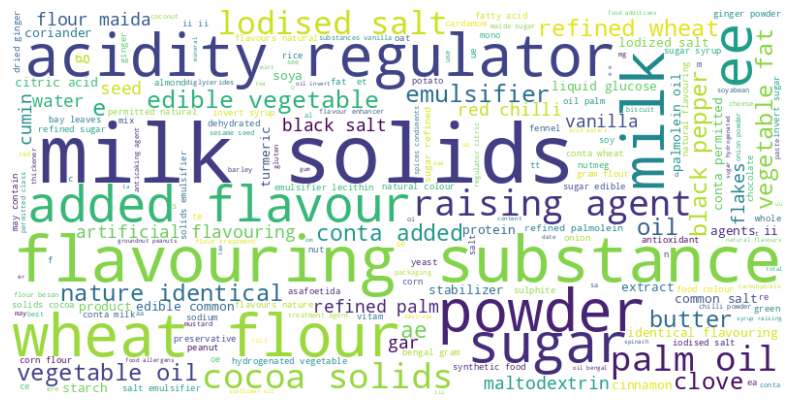

In [33]:
plot_wordcloud_by_feature_name(df_ingr,"Ingredients_processed")

### 5.2 Removing Invalid ingredients

#### 5.2.1 Expanding Ingredients

In [34]:
# Split the column values by comma and create a new column as a list of values
df_ingr['Ingredients_processed'] = df_ingr['Ingredients_processed'].str.split(',')

# Explode the list of values into separate rows
df_ingr = df_ingr.explode('Ingredients_processed')

# Reset the index
df_ingr = df_ingr.reset_index(drop=True)

# Trim leading and trailing spaces
df_ingr['Ingredients_processed'] = df_ingr['Ingredients_processed'].str.strip()

# Remove extra spaces within the column values
df_ingr['Ingredients_processed'] = df_ingr['Ingredients_processed'].str.replace('\s+', ' ', regex=True)

####5.2.2 Removing short words

In [36]:
# Removing words less than 2 characters
def remove_short_length_words(text):
  text = text.strip()
  return ' '.join(word for word in text.split() if len(word.strip())>2)

In [37]:
df_ingr['Ingredients_processed'] = df_ingr['Ingredients_processed'].apply(lambda x : remove_short_length_words(x))

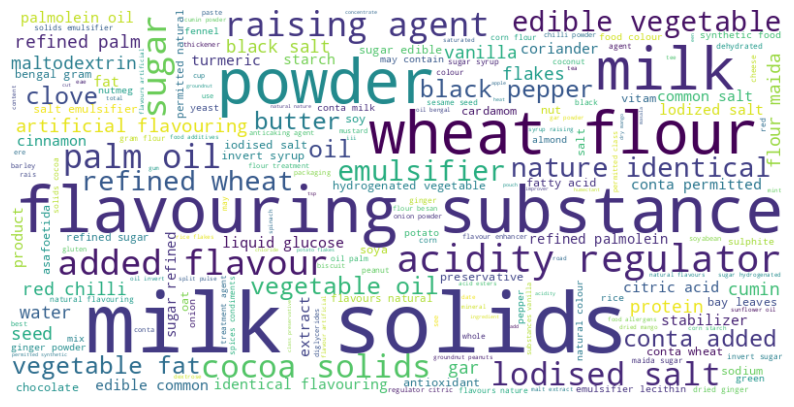

In [38]:
plot_wordcloud_by_feature_name(df_ingr,"Ingredients_processed")

#### 5.2.3 Re-validating Ingredients

In [39]:
filtered_df = df_ingr[df_ingr['Ingredients_processed'].str.len() <= 3]
filtered_df["Ingredients_processed"].unique()

array(['', 'mom', 'cou', 'nut', 'soy', 'gar', 'iii', 'meg', 'sug', 'bht',
       'nee', 'pos', 'itc', 'ida', 'itl', 'raw'], dtype=object)

#### 5.2.4 Removing Invalid Ingredients - II

In [40]:
invalid_ingredients = ['', 'mom', 'cou', 'gar', 'iii', 'bht','nee', 'pos', 'itc', 'nehru road','ense','ida', 'itl','rais','geng','pond','tors','floor', 'mumbai','howrah','arjun','taxes']
df_ingr = df_ingr[~df_ingr['Ingredients_processed'].isin(invalid_ingredients)]

In [41]:
filtered_df = df_ingr[df_ingr['Ingredients_processed'].str.len() <= 3]
filtered_df["Ingredients_processed"].unique()

array(['nut', 'soy', 'meg', 'sug', 'raw'], dtype=object)

#### 5.2.5 Auto-correcting Misspelled Ingredients

In [42]:
corrected_ingr_map = {
    'lour':'flour',
    'suga':'sugar',
    'nut':'nuts',
    'syvp':'syrup',
    'atulsi': 'tulsi',
    'cumim':'cumin',
    'jrose':'rose',
    'ccont':'coconut',
    'sooii':'sooji',
    'orice':'rice',
    'wutmeg':'nutmeg',
    'natu':'natural',
    'wder': 'powder',
    'bay aves':'bay leaves',
    'olein oil':'pamolein oil',
    'carrotsi':'carrots',
    'chili':'chilli'}

df_ingr=df_ingr.replace({"Ingredients_processed": corrected_ingr_map})

In [43]:
filtered_df = df_ingr[df_ingr['Ingredients_processed'].str.len() <= 6]
filtered_df["Ingredients_processed"].unique()

array(['cumin', 'clove', 'potato', 'nutmeg', 'besan', 'ajowan', 'sago',
       'chilli', 'dates', 'flour', 'imond', 'gluten', 'soya', 'black',
       'cashew', 'mace', 'starch', 'flakes', 'sugar', 'nuts', 'soy',
       'milk', 'oats', 'salt', 'carrot', 'water', 'ginger', 'amchur',
       'pepper', 'vitam', 'leeks', 'color', 'acid', 'yeast', 'rose',
       'butter', 'solids', 'herbs', 'eggs', 'almond', 'lime', 'shea',
       'illipe', 'meg', 'cheese', 'sug', 'sogo', 'coffee', 'powder',
       'garli', 'katha', 'onion', 'cloves', 'cassia', 'fennel', 'honey',
       'syrup', 'ponae', 'bark', 'poms', 'fcsn', 'tundel', 'sooji',
       'wheat', 'tulsi', 'gokhru', 'sonth', 'lavang', 'rice', 'khasra',
       'onions', 'mint', 'raw', 'jander'], dtype=object)

In [44]:
filtered_df = df_ingr[(df_ingr['Ingredients_processed'].str.len() > 6) & (df_ingr['Ingredients_processed'].str.len() <= 10)]
filtered_df["Ingredients_processed"].unique()

array(['turmeric', 'cardamom', 'bay leaves', 'black salt', 'ack pepper',
       'gar powder', 'asafoetida', 'bay leaf', 'cinnamon', 'black set',
       'green peas', 'red chil', 'spinach', 'red chilli', 'groundnut',
       'red hill', 'cardamorn', 'poe clove', 'cardo aint', 'rock salt',
       'poppy seed', 'tree nuts', 'lent masur', 'dnut fanut', 'used iger',
       'ingredient', 'coriander', 'black ler', 'corn meal', 'rice flour',
       'dextrose', 'nutrients', 'tumeric', 'fenugreek', 'semolina',
       'carrots', 'vinegar', 'thickeners', 'stabilizer', 'palm oil',
       'emulsifier', 'sweetener', 'mustard', 'riboflavin', 'corn oil',
       'minerals', 'min erals', 'dbiotin', 'chocolate', 'glucose',
       'conta wein', 'improver', 'dised salt', 'humectant', 'wheat bran',
       'humectants', 'britannia', 'margarine', 'saffron', 'coconut',
       'red chill', 'palm olein', 'natural', 'cocoa mass', 'colours',
       'vitamin', 'cup maida', 'tsp salt', 'tbsp milk', 'gar flakes',
     

##### 5.2.5.2 Contextual spell correction

In [45]:
incorrect_ingr = ['com sich', 'corn flour', 'thickener', 'parsley', 'paimolein','com flouf', 'com starch', 'com flour']
df_ingr_spell_correction = df_ingr[df_ingr['Ingredients_processed'].isin(incorrect_ingr)]
df_ingr_spell_correction['Ingredients_processed'].head()

1351      com sich
1365    corn flour
1384    corn flour
1386     thickener
1397    corn flour
Name: Ingredients_processed, dtype: object

In [46]:
# source - https://www.scaler.com/topics/nlp/create-a-spell-check-with-nlp/
try:
    import contextualSpellCheck
except:
    ! pip install contextualSpellCheck
    import contextualSpellCheck

try:
    import spacy
except:
    ! pip install contextualSpellCheck
    import spacy

nlp = spacy.load('en_core_web_sm')
contextualSpellCheck.add_to_pipe(nlp)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 94.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 99.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.5 MB/s eta 0:00:00
  Created wheel for editdistance: filename=editdistance-0.6.0-cp310-cp310-linux_x86_64.whl size=235607 sha256=008ed65ec80182afe873b633be44042e7e16386ef8cf909d1dd18080ff31e005
  Stored in directory: /root/.cache/pip/wheels/d2/c2/60/295c59f8772b195d952c943f53ac4936e4ac59fc47a0030a1a
Successfully built editdistance
  Attempting uninstall: editdistance
    Found existing installation: editdistance 0.6.2
    Uninstalling editdistance-0.6.2:
      Successfully uninstalled editdistance-0.6.2


In [47]:
doc = nlp('I have added two spoons of corm flour')

# This shows the number of corrections in the input text.
print(len(doc._.suggestions_spellCheck))

# This shows all the actual corrections that were made with the associated mapping.
print(doc._.suggestions_spellCheck)

# This displays the outcome after spelling correction
print(doc._.outcome_spellCheck)

1
{spoons: 'pounds'}
I have added two pounds of corm flour


- **Conslusion** :
  - Not getting great results from spell correction model
  - Needs to fine tune to correct miss-spelled ingredients names , which might have been generated during image to text convertion

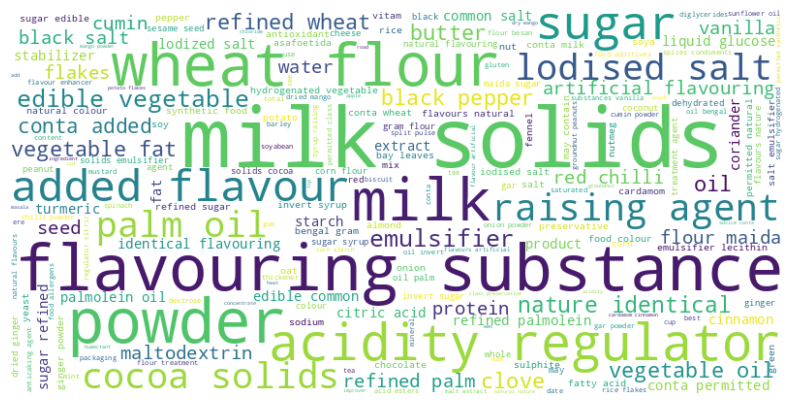

In [48]:
plot_wordcloud_by_feature_name(df_ingr,"Ingredients_processed")

In [49]:
ingredients = df_ingr[["Product_name","Ingredients_processed"]]

#### 5.3 Ingredients often used

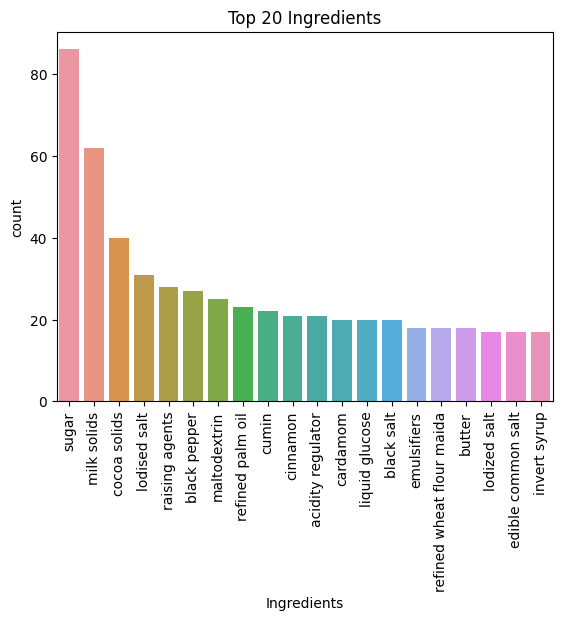

In [50]:
#Univariate Analysis Categorical features
x=ingredients["Ingredients_processed"].value_counts(ascending=False).head(20).index
y=ingredients["Ingredients_processed"].value_counts(ascending=False).head(20).values
sns.barplot(x=x,y=y)
plt.xticks(rotation=90)
plt.xlabel("Ingredients")
plt.ylabel("count")
plt.title("Top 20 Ingredients")
plt.show()

## 6. Clustering

In [51]:
df_ingr[["Product_name","Ingredients_processed"]].head()

,Product_name,Ingredients_processed
0,20002976-3_1-haldirams-namkeen-masala-peanut,groundnut peanuts
1,20002976-3_1-haldirams-namkeen-masala-peanut,refined palmolein
2,20002976-3_1-haldirams-namkeen-masala-peanut,mixed spices red chilli
3,20002976-3_1-haldirams-namkeen-masala-peanut,turmeric
4,20002976-3_1-haldirams-namkeen-masala-peanut,black pepper


### 6.1 TF-IDF Vectorization

In [52]:
# TF-IDF representation of the dataset Using TfidfVectorizer from scikit-learn
tfidf_vectorizer = TfidfVectorizer(min_df=5)
# min_df: ignore terms that have a document frequency strictly lower than the given threshold.
tfidf_features = tfidf_vectorizer.fit_transform(df_ingr["Ingredients_processed"]).todense()  # todense() returns a matrix
# create dataframe
tfidf_features_df = pd.DataFrame(tfidf_features)
tfidf_features_df.columns = tfidf_vectorizer.get_feature_names_out()  # Get output feature names for dataframe columns.
tfidf_features_df.columns
tfidf_features_df.index = df_ingr["Ingredients_processed"]
display(tfidf_features_df)

,aaa,acetate,acid,acidity,acids,add,added,additives,address,advice,...,vegetable,vegetables,vitam,water,well,wheat,which,whole,with,yeast
Ingredients_processed,,,,,,,,,,,,,,,,,,,,,
groundnut peanuts,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
refined palmolein,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
mixed spices red chilli,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
turmeric,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
black pepper,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
green peas,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
spinach,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
refined wheat flour maida,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.455888,0.0,0.0,0.0,0.0


### 6.2 Scaling & Clustering

#### 6.2.1 Scaling

In [53]:
scaler = StandardScaler()
scaler.fit(tfidf_features_df)
X=scaler.transform(tfidf_features_df)

#### 6.2.2 K-means Clustering

In [54]:
# K has been defined based on iterative process wherein
# elbow is forming .

k = 230
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X)

#### 6.2.3 Validating Clusters

In [55]:
# Inertia = Within Cluster Sum of Squares
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1,500,10)]
inertias = [model.inertia_ for model in kmeans_per_k]

##### 6.2.3.1 Elbow method

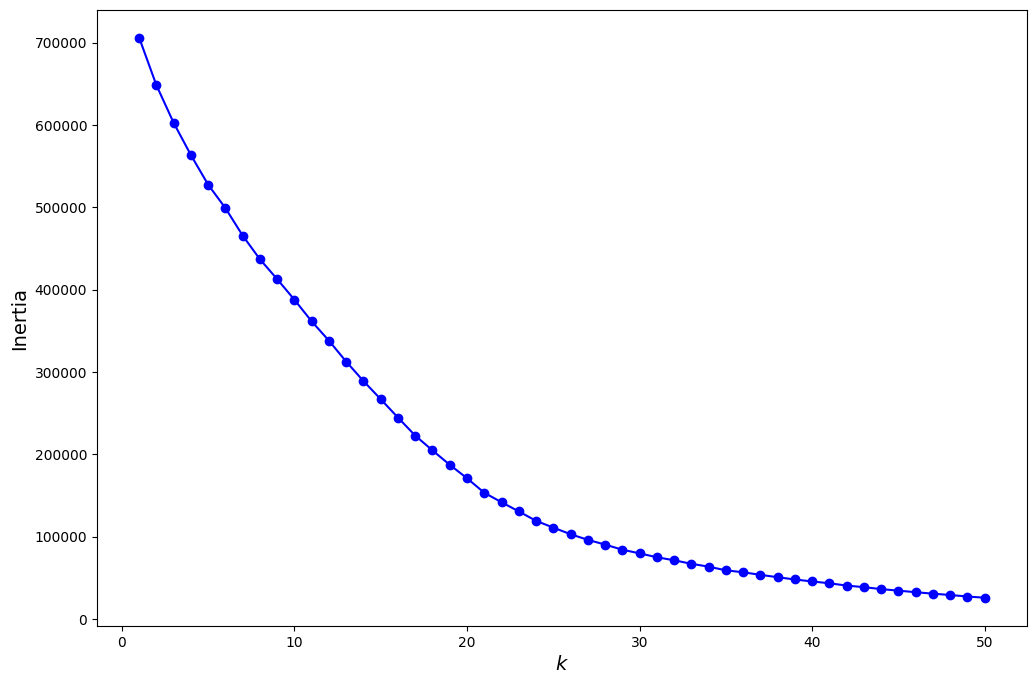

In [56]:
plt.figure(figsize=(12, 8))
plt.plot(range(1, len(inertias)+1), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.show()

##### 6.2.3.2 Plotting cluster points

##### 6.2.3.1 Cluster vs Associated points

In [57]:
points_count_dict = {}
#points_in_cluster_dict = {}
for cluster_number in range(1, k+1):
  # Loop through each cluster number from 1 to k
  # Count the number of points assigned to each cluster
  points_count_dict[cluster_number] = len(np.where(y_pred == cluster_number)[0])
  # collection of points to each cluster
  # points_in_cluster_dict[cluster_number] = X[y_pred == cluster_number]

res = dict(sorted(points_count_dict.items(), key = lambda x: x[1], reverse = True)[:10])
selected_clusters = res.keys()
# Cluster vs number of points associated
print("Top clusters vs points " + str(res))

Top clusters vs points {1: 283, 76: 108, 19: 92, 32: 45, 168: 43, 29: 41, 40: 41, 47: 39, 45: 37, 65: 37}


##### 6.2.3.2 Plot top clusters

###### 6.2.3.2.1 Cluster wordclouds

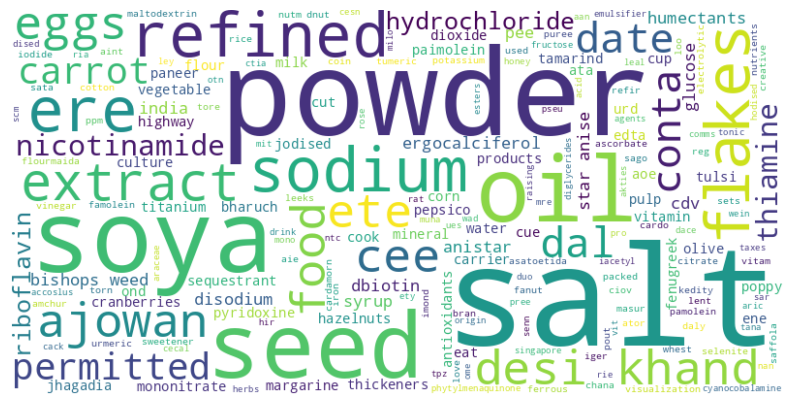

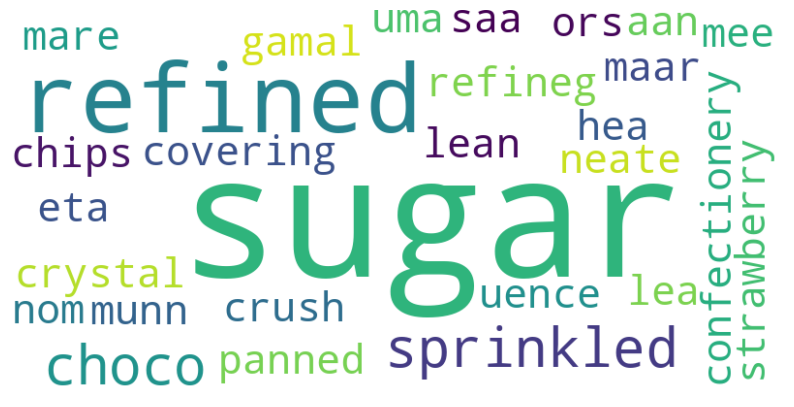

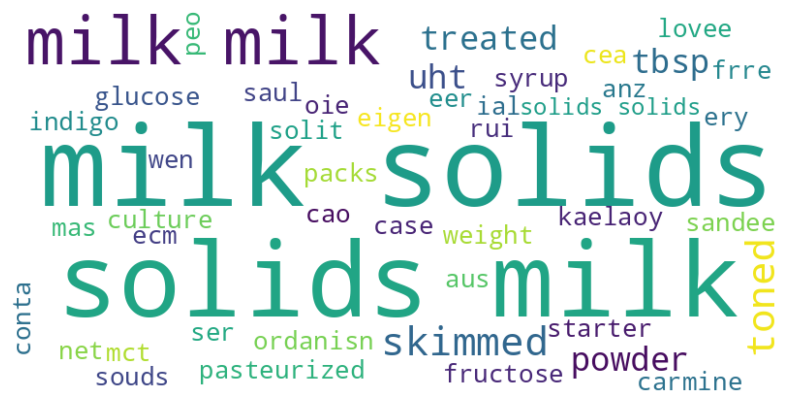

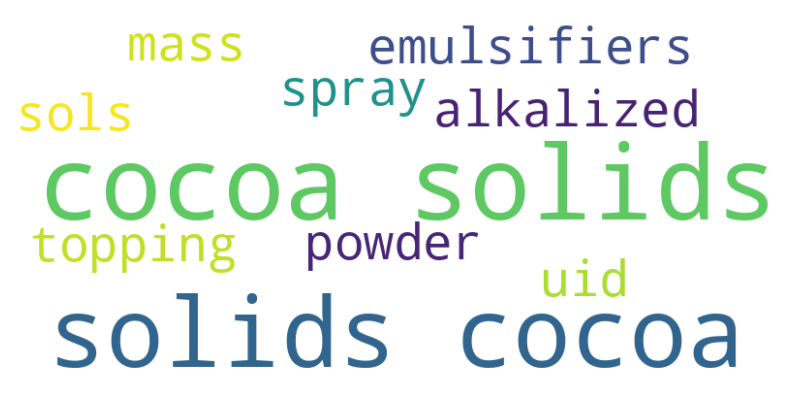

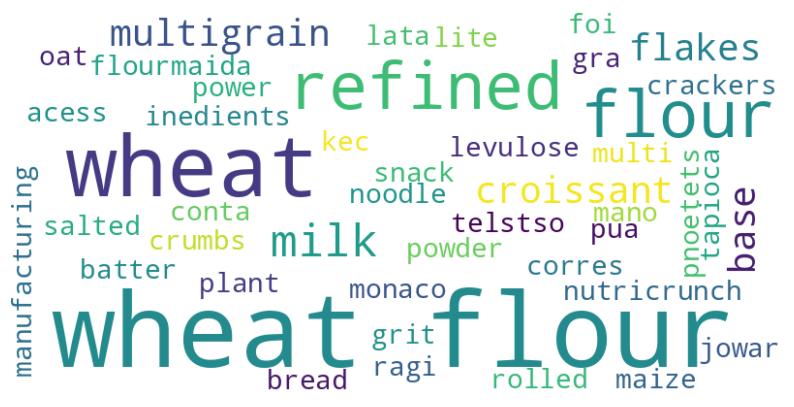

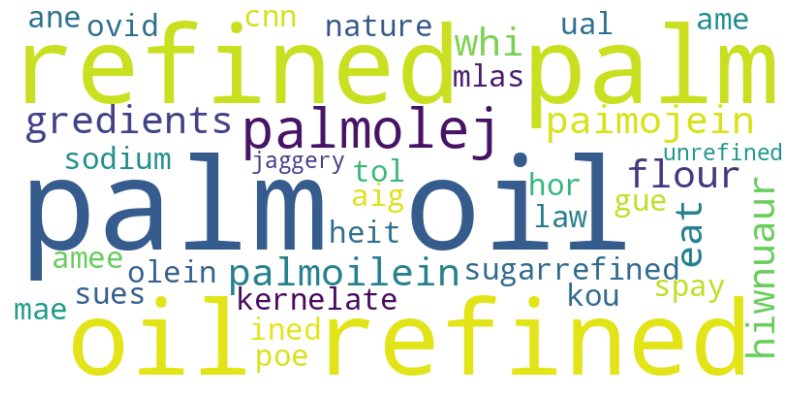

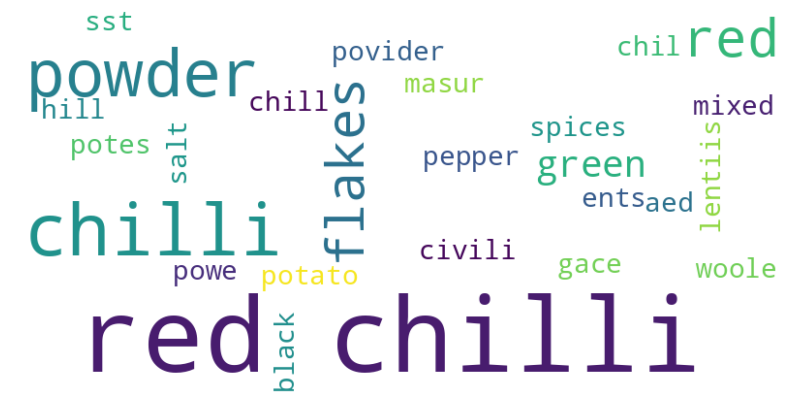

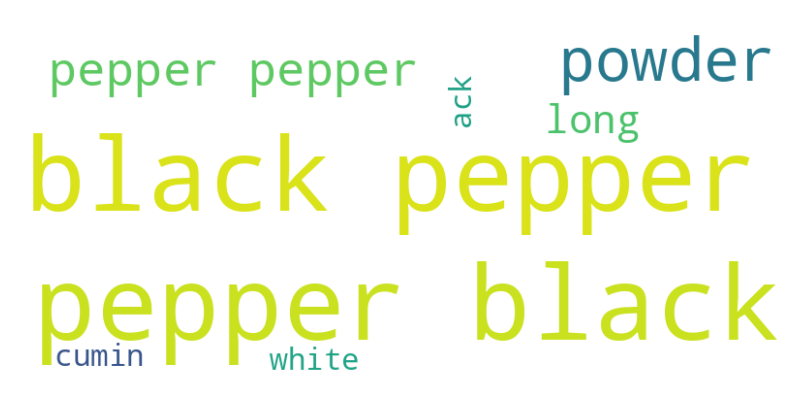

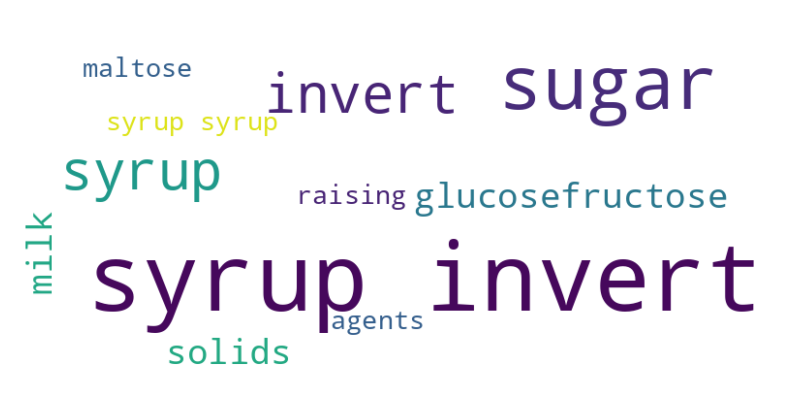

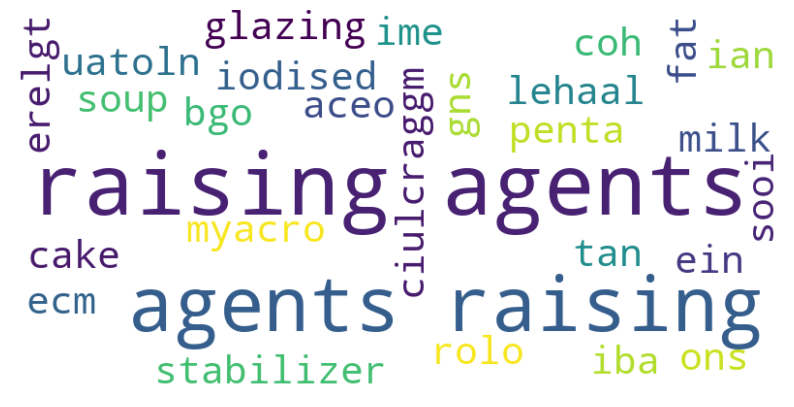

In [93]:
def plot_cluster_wordcloud(cluster_num):
    # Concatenate text from selected cluster
    text = ""
    for cluster_index, ingr_val in zip(y_pred, df_ingr["Ingredients_processed"].values):
        if cluster_index == cluster_num:
            text += " " + ingr_val

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Plot the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


for cluster_number in selected_clusters:
  plot_cluster_wordcloud(cluster_number)
  print()
  print()

###### 6.2.3.2.2 Vectorization and Visualization (t-SNE)

In [78]:
def plot_tsne_with_vectorizer(vectorizer, df, column_name, row_indexes):
    # Get the data from the specified column and filter by row indexes
    if row_indexes is not None and len(row_indexes) > 0:
        data = df.loc[row_indexes, column_name].values
    else:
        data = df[column_name].values

    # Vectorize the data
    embedding = vectorizer.fit_transform(data)

    # Reduce dimensionality with t-SNE
    tsne = TSNE(n_components=2, init='random')  # Specify init='random'
    embedding_tsne = tsne.fit_transform(embedding.toarray())  # Convert sparse matrix to dense array

    # Plot the t-SNE representation
    plt.scatter(embedding_tsne[:, 0], embedding_tsne[:, 1])
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.title('t-SNE Visualization')

    # Show the plot
    plt.show()

In [82]:
def find_top_cluster_row_indexes(selected_clusters,df):
    top_cluster_row_indexs = []

    for cluster_num in selected_clusters:
      for cluster_index,ingr_row_index in zip(y_pred,df.index):
        if cluster_index == cluster_num:
            top_cluster_row_indexs.append(ingr_row_index)

    return top_cluster_row_indexs

###### 6.2.3.2.3 TFIDF with all data points

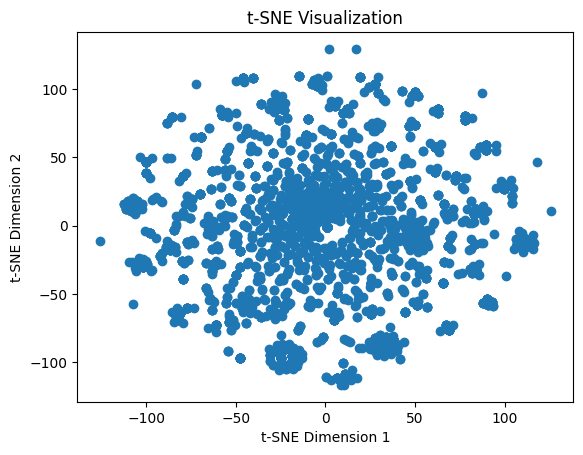

In [79]:
# TF-IDF representation of the dataset Using TfidfVectorizer from scikit-learn
tfidf_vectorizer = TfidfVectorizer(min_df=5)
plot_tsne_with_vectorizer(tfidf_vectorizer, df_ingr, "Ingredients_processed", None)

In [89]:
print("Top clusters vs number of indexes " + str(res))
top_cluster_row_indexs = find_top_cluster_row_indexes(selected_clusters,df_ingr)
print("Top cluster selected row indexes",len(top_cluster_row_indexs))

Top clusters vs number of indexes {1: 283, 76: 108, 19: 92, 32: 45, 168: 43, 29: 41, 40: 41, 47: 39, 45: 37, 65: 37}
Top cluster selected row indexes 766


###### 6.2.3.2.4 TFIDF with Kmeans top cluster data points

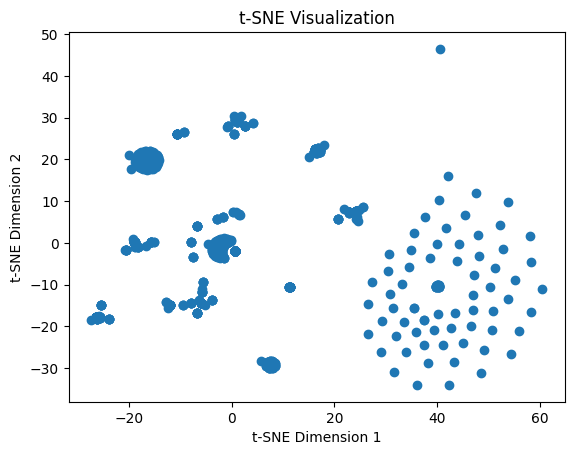

In [90]:
plot_tsne_with_vectorizer(tfidf_vectorizer, df_ingr, "Ingredients_processed", top_cluster_row_indexs)

###### 6.2.3.2.5 TFIDF (biagram) with Kmeans ALL cluster data points

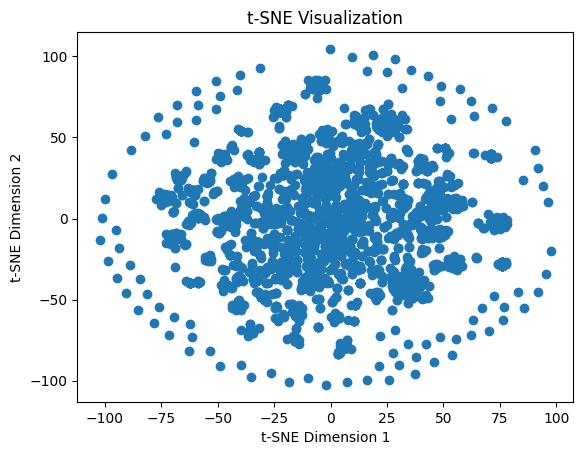

In [94]:
# Bigram using TfidfVectorizer
biagram_tf_idf_vectorizer = TfidfVectorizer(ngram_range=(1,2))
plot_tsne_with_vectorizer(biagram_tf_idf_vectorizer, df_ingr, "Ingredients_processed", None)

###### 6.2.3.2.6 TFIDF (biagram) with Kmeans TOP cluster data points

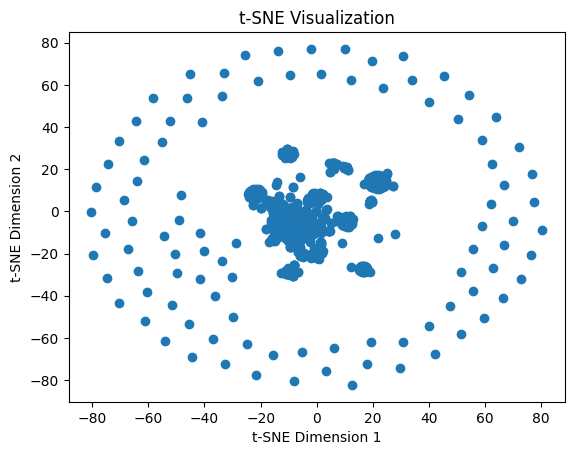

In [95]:
plot_tsne_with_vectorizer(biagram_tf_idf_vectorizer, df_ingr, "Ingredients_processed", top_cluster_row_indexs)

#### 6.2.4 Hierarchical Clustering

In [272]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(n_clusters=5)
model = model.fit(tfidf_features_df.to_numpy())

Text(0, 0.5, 'distance')

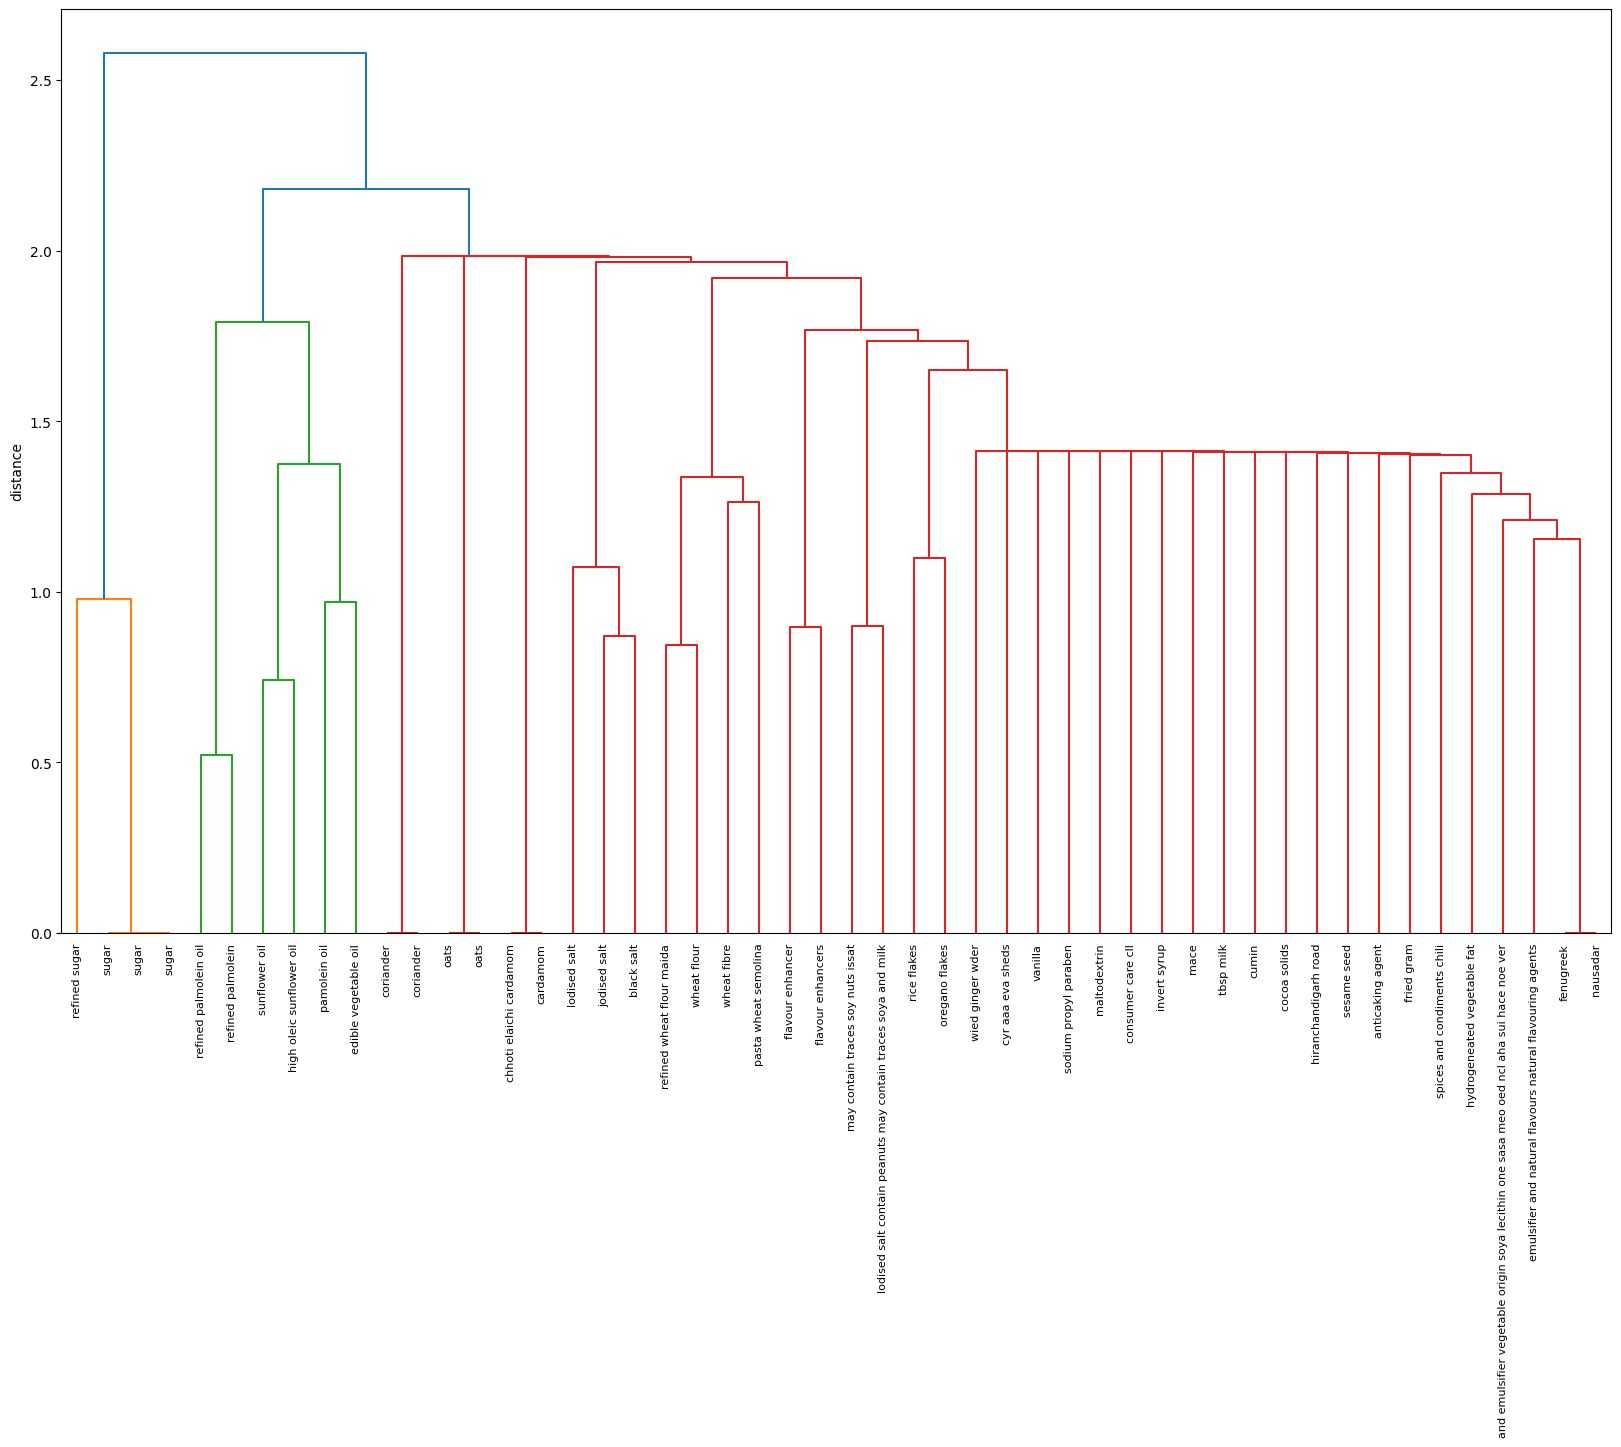

In [273]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

sample = tfidf_features_df.sample(50)
Z = sch.linkage(sample, method='ward')

fig, ax = plt.subplots(figsize=(20, 12))
sch.dendrogram(Z, labels=sample.index, ax=ax, color_threshold=2)
plt.xticks(rotation=90)
ax.set_ylabel('distance')

### 6.3 GloVe (Global Vectors for Word Representation)
GloVe is another popular word embedding technique developed by researchers at Stanford University. It uses a **co-occurrence matrix** to capture the global statistics of word co-occurrences in a large corpus. GloVe aims to learn word vectors that **represent both the local context (as in Word2Vec) and the global word co-occurrence statistics**.

Advantages of GloVe:

- Captures global context: GloVe focuses on global statistics and is designed to capture long-range semantic relationships between words.
- Interpretable vector arithmetic: GloVe embeddings often exhibit meaningful linear substructures, allowing for algebraic operations on word vectors ("king" - "man" + "woman" ≈ "queen").
- Works well with limited training data: GloVe has been shown to perform relatively well even with smaller training datasets.

P.S : **Global word co-occurrence statistics** refer to the **patterns of words appearing together in a given corpus or collection of texts**. It measures how often words co-occur within a specific context, such as within the same sentence, paragraph, or document. These statistics provide valuable insights into the relationships and associations between words in a broader linguistic context.

#### 6.3.1 Vectorization

In [278]:
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# Convert GloVe format to Word2Vec format
glove_input_file = GLOVE_CONFIG_DIR+'/'+GLOVE_FILENAME # Replace with the path to your GloVe vectors file
word2vec_output_file = GLOVE_CONFIG_DIR+'/glove_vectors.word2vec'

glove2word2vec(glove_input_file, word2vec_output_file)

# Load GloVe word vectors in Word2Vec format
word_vectors = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

# Function to compute average word vectors for a text
def compute_average_vector(text):
    vectors = [word_vectors[word] for word in text if word in word_vectors]
    #print(len(vectors), len(vectors[0]), len(sum(vectors)))
    if vectors:
        return sum(vectors) / len(vectors)
    else:
        return None

# Compute average word vectors for each text in the DataFrame
embeddings = df_ingr["Ingredients_processed"].apply(lambda x: x.split()).apply(compute_average_vector)

# Example: Accessing embedding for a specific row
row_index = 0
embedding = embeddings[row_index]
print(f"Embedding for row {row_index}: {embedding}")

Embedding for row 0: [-0.2103509  -0.18513     0.26059002  0.33995003 -0.055771    0.458365
 -0.0495465  -0.0894835  -0.078887    0.530055   -0.05511    -0.35914
  0.0516045   0.37865    -0.24077     0.176955    0.10807651  0.291865
 -0.205415   -0.21320501  0.16115001 -0.10143501 -0.239532    0.00780001
 -0.02054501  0.531426   -0.4571     -0.022628   -0.43068302  0.029975
 -0.57419     0.1635985  -0.44503498 -0.172569    0.4311535   0.305554
  0.14219901  0.72717    -0.03625    -0.332355   -0.321915   -0.449065
 -0.06525001 -0.25164     0.496305   -0.253185   -0.170845    0.049842
 -0.03954001  0.3796505   0.579801   -0.1062854   0.415295    0.087227
  0.16413498 -0.05667     0.01811501  0.15421051  0.76817    -0.63532
 -0.22610499 -0.25574     0.01183501  0.276535   -0.09789568  0.592415
  0.157985    0.009345    0.08475499  0.08583701 -0.07066999 -0.03508
 -0.32113    -0.45974    -0.04731    -0.18803349  0.343265   -0.07385
  0.306885    0.243947    0.32852    -0.16429    -0.175607

#### 6.3.2 Plotting Embeddings

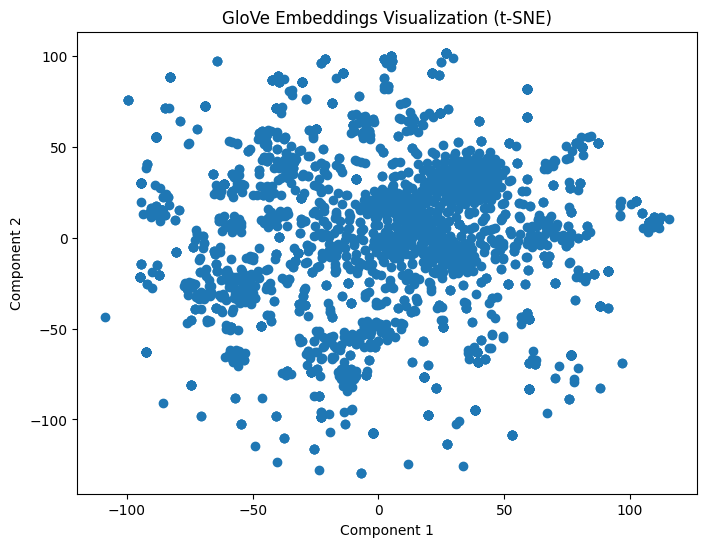

In [279]:
# Remove any rows with missing embeddings
embeddings = embeddings.dropna()

# Convert embeddings to a 2D numpy array
embeddings_array = np.vstack(embeddings.values)

# Perform dimensionality reduction using t-SNE
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings_array)

# Create a scatter plot of the reduced embeddings
plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])
plt.title('GloVe Embeddings Visualization (t-SNE)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()